<a href="https://colab.research.google.com/github/KuanWeiBeCool/Weather-Predictions-Using-Deep-Learning/blob/main/Weather_Predictions_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
!pip install pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/drive/MyDrive/Machine Learning/McGill ESCE 552/Assignment 5'

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/17LOP5bnXDSCkg2HFSqgbNhfy31zccgfv/HW5


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
# Create checkpoint callback that monitors validation loss
class LitAutoEncoder(pl.LightningModule):
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.backbone(x)

        # 1. calculate loss
        loss = F.cross_entropy(y_hat, y)

        # 2. log `val_loss`
        self.log('val_loss', loss)

In [ ]:
# Logger for pytorch trainer
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import LightningLoggerBase
from pytorch_lightning.loggers.base import rank_zero_experiment
from collections import defaultdict 


class DictLogger(LightningLoggerBase):

    def __init__(self):
        super().__init__()
        def def_value(): 
            return []
              
        # Defining the dict 
        self.metrics = defaultdict(def_value) 


    @property
    def name(self):
        return 'DictLogger'

    @property
    @rank_zero_experiment
    def experiment(self):
        # Return the experiment object associated with this logger.
        pass

    @property
    def version(self):
        # Return the experiment version, int or str.
        return '0.1'

    @rank_zero_only
    def log_hyperparams(self, params):
        # params is an argparse.Namespace
        # your code to record hyperparameters goes here
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        # metrics is a dictionary of metric names and values
        # your code to record metrics goes here
        for key in metrics.keys():
            self.metrics[key].append(metrics[key])

    @rank_zero_only
    def save(self):
        # Optional. Any code necessary to save logger data goes here
        # If you implement this, remember to call `super().save()`
        # at the start of the method (important for aggregation of metrics)
        super().save()

    @rank_zero_only
    def finalize(self, status):
        # Optional. Any code that needs to be run after training
        # finishes goes here
        pass

# Data Visualization and Featrue Engineering

In [ ]:
train_df = pd.read_csv('weather_train.csv')
train_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


First, let's visualize our targets:


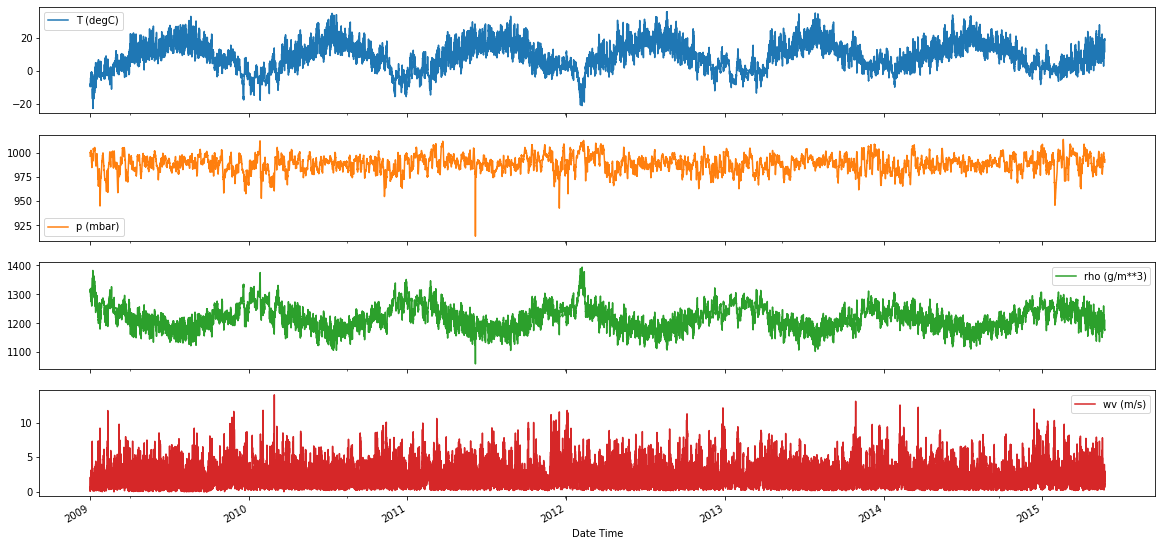

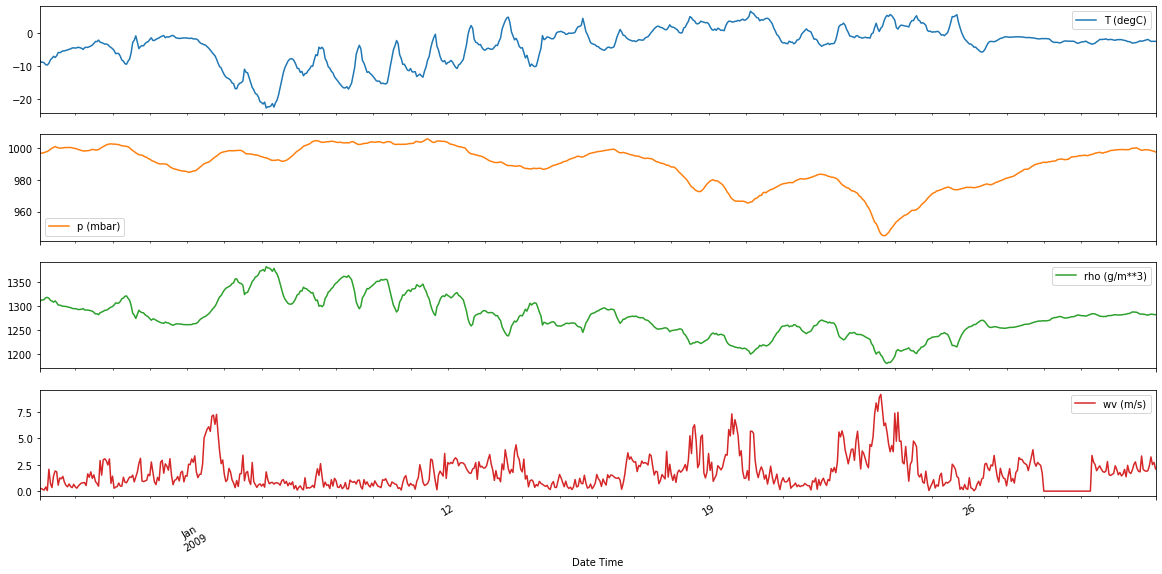

In [ ]:
date_time = pd.to_datetime(train_df['Date Time'], format='%d.%m.%Y %H:%M:%S')
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'wv (m/s)']
plot_features = train_df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(20, 10))

# Plot for the first 30 days
plot_features = train_df[plot_cols][:720]
plot_features.index = date_time[:720]
_ = plot_features.plot(subplots=True, figsize=(20, 10))

It looks like all targets have some time dependency. Now let's look at the statistics of the dataset:

In [ ]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),56072.0,988.832928,8.350194,913.60,983.8100,989.240,994.3100,1013.91
T (degC),56072.0,8.987746,8.440986,-22.76,2.8800,8.970,15.0700,35.65
Tpot (K),56072.0,283.059875,8.518036,250.85,277.0000,283.100,289.1300,309.73
Tdew (degC),56072.0,4.551409,6.830787,-24.80,-0.1200,4.745,9.7325,23.06
rh (%),56072.0,76.208224,16.498261,13.88,65.4975,79.500,89.6000,100.00
VPmax (mbar),56072.0,13.170791,7.479040,0.97,7.5200,11.470,17.1600,58.34
VPact (mbar),56072.0,9.297106,4.150333,0.81,6.0500,8.575,12.0800,28.25
VPdef (mbar),56072.0,3.873606,4.673326,0.00,0.8200,2.090,5.1000,41.78
sh (g/kg),56072.0,5.874655,2.634644,0.51,3.8200,5.410,7.6300,18.07
H2OC (mmol/mol),56072.0,9.404474,4.201705,0.81,6.1200,8.680,12.2100,28.74


Apparently, large range differences exist between features. For example, temperature data has a mean value of 8.98, while pressure data has a mean of 988.8. Therefore, normalization process is required. However, before normalization, we can create some new features that are potentially useful.

From our experience, we know that usually temperature has a periodic performance in days and years. The temperature at 23:00 should be similar to the temperature at 00:00. However, if we represent the time as normal date time values, it is very hard to capture the similarity since 0 is far away from 23. Thus, we can represent time in a different format.

First, let's check what are the important frequencies for each target:

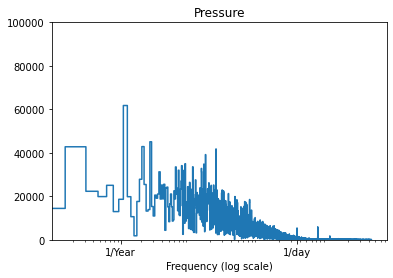

In [ ]:
fft = tf.signal.rfft(train_df['p (mbar)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_df['p (mbar)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.title('Pressure')
_ = plt.xlabel('Frequency (log scale)')

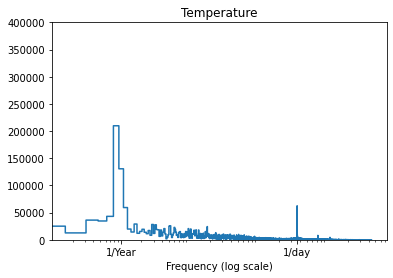

In [ ]:
import tensorflow as tf
fft = tf.signal.rfft(train_df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.title('Temperature')
_ = plt.xlabel('Frequency (log scale)')

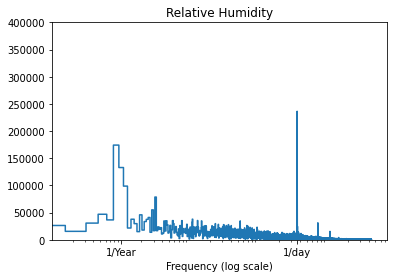

In [ ]:
fft = tf.signal.rfft(train_df['rh (%)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_df['rh (%)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.title('Relative Humidity')
_ = plt.xlabel('Frequency (log scale)')

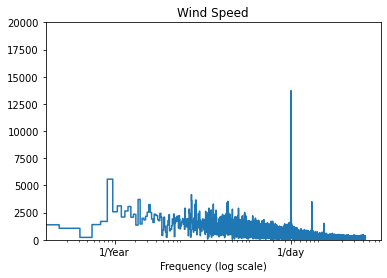

In [ ]:
fft = tf.signal.rfft(train_df['wv (m/s)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_df['wv (m/s)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 20000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.title('Wind Speed')
_ = plt.xlabel('Frequency (log scale)')

As can be seen from the above figures, temperature, relative humidity, and wind speed have high periodicity on day and year. Thus, we can modify the time data based on the periods. The most popular functions with periodicity are sine and cosine waves. So we'll convert the periods into sine and cosine waves.

In [ ]:
# Convert day and year into periodic data
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = 365.2425*day

train_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

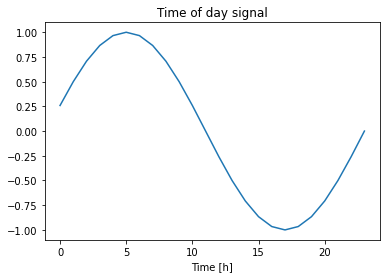

In [ ]:
plt.plot(np.array(train_df['Day sin'])[:24], label='Day')
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Another set of features that may require additional preprocessing is the wind speed and the wind angle. Wind angle in this dataset is presented as degrees, which is not a clear way for machines, as the difference in values may not represent the actual difference in angles. For example, 359 degrees and 0 degrees should be very close, but their magnitudes are very different. Therefore, we can instead represent wind as a 2D vector, where the magnitude is the wind speed, and the angle is the wind angle.  

Right now, as can be seen from the image below, we cannot extract much useful information:

Text(0, 0.5, 'Wind Speed [m/s]')

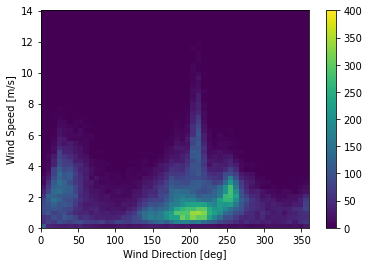

In [ ]:
plt.hist2d(train_df['wd (deg)'], train_df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Speed [m/s]')

In [ ]:
# Convert to vector component
wv = train_df['wv (m/s)']
max_wv = train_df['max. wv (m/s)']

# Convert to radians.
wd_rad = train_df['wd (deg)']*np.pi / 180

# Calculate the wind x and y components.
train_df['Wx'] = wv*np.cos(wd_rad)
train_df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
train_df['max Wx'] = max_wv*np.cos(wd_rad)
train_df['max Wy'] = max_wv*np.sin(wd_rad)

Now, the information is more organized and meaningful:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

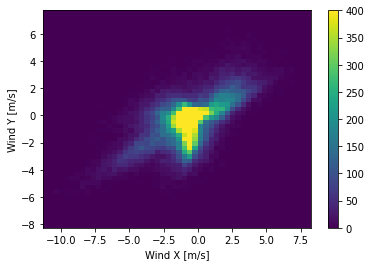

In [ ]:
plt.hist2d(train_df['Wx'], train_df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

# Train and Validation Split

Since we've got a training set and a test set, we need to split the training set into training data and validation data.

In [ ]:
# 80% for train and 20% for validation
n = len(train_df)
train_data = train_df[:int(n*0.8)]
valid_data = train_df[int(n*0.8):]

# Standardization

As discussed before, ranges for different features vary significantly in our dataset. Machine learning models may consider values that are larger to be more important. This can create bias for our model. Therefore, we use standardization to normalize the dataset. 

In [ ]:
train_data = train_data.iloc[:, 1:] # Remove the date time column since we've represented the date time in sine and cosine format
valid_data = valid_data.iloc[:, 1:]

train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean)/train_std
valid_data = (valid_data - train_mean)/train_std

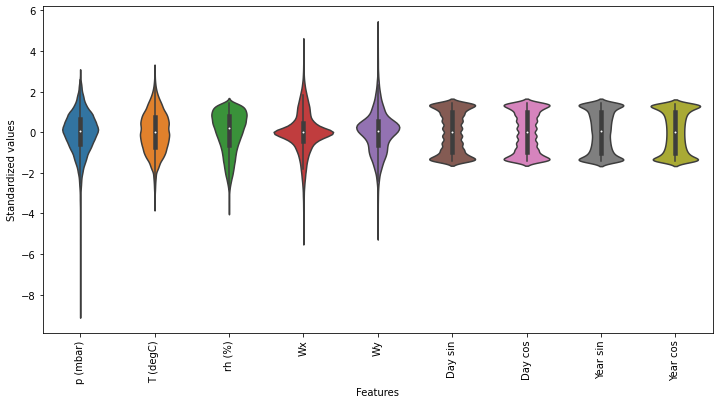

In [ ]:
# Columns that we will use to make predictions
columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
df_std = train_data[columns]
df_std = df_std.melt(var_name='Features', value_name='Standardized values') # To make the violin plot, we can only have one column for x and one column for y
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Features', y='Standardized values', data=df_std)
_ = ax.set_xticklabels(columns, rotation=90)

Now, even though some columns such as p (mbar) and max. wv (m/s) still have long tails, they all centered around 0 and the variations are much smaller. 

# Creating Sliding Windows

In this project, we use a fixed number of time points to make predictions for the future time points. Thus, we need to create windows. 

In [ ]:
train_data_final = train_data[columns].to_numpy()
valid_data_final = valid_data[columns].to_numpy()

In [ ]:
# Create sliding windows
def sliding_windows(data, window_size, num_of_output, flatten=False):
  """
  Function to expand features to a sliding window
  The first "num_of_output" columns of data are taken as outputs
  If flatten is set to True:
    New number of features = number of features * sliding window size
    New number of time steps = number of time steps - sliding window size
  """
  x = []
  y = []
  for i in range(len(data)-window_size-1):
    _x = data[i:(i+window_size), :]
    _y = data[i+window_size, :num_of_output]
    x.append(_x)
    y.append(_y)

  x = np.array(x)
  y = np.array(y)
  
  # Flatten the feature and window dimensions
  if flatten:
    x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
  return (torch.from_numpy(x).float(), torch.from_numpy(y).float())

window_size = 8
num_of_output = len(columns)
# For Dense Layer Neural Network, we need to flat the input
train_X_FF, train_y_FF = sliding_windows(train_data_final, window_size, num_of_output, flatten=True)
valid_X_FF, valid_y_FF = sliding_windows(valid_data_final, window_size, num_of_output, flatten=True)

# For RNN, we don't need to flat the input
train_X_RNN, train_y_RNN = sliding_windows(train_data_final, window_size, num_of_output, flatten=False)
valid_X_RNN, valid_y_RNN = sliding_windows(valid_data_final, window_size, num_of_output, flatten=False)

In [ ]:
# Dense Layers NN
train_data_FF = TensorDataset(train_X_FF, train_y_FF)
valid_data_FF = TensorDataset(valid_X_FF, valid_y_FF)

train_dataloader_FF = DataLoader(train_data_FF, batch_size=20, shuffle=True)
valid_dataloader_FF = DataLoader(valid_data_FF, batch_size=20, shuffle=True)

# RNN
train_data_RNN = TensorDataset(train_X_RNN, train_y_RNN)
valid_data_RNN = TensorDataset(valid_X_RNN, valid_y_RNN)

train_dataloader_RNN = DataLoader(train_data_RNN, batch_size=20, shuffle=True)
valid_dataloader_RNN = DataLoader(valid_data_RNN, batch_size=20, shuffle=True)

# Model Training

## Baseline (Dense Layers NN)
First, we create a baseline, which is essentially a fully-connected feedforward neural network:

In [ ]:
# Lightning Module

class FFNetwork(pl.LightningModule):
  def __init__(self, num_features, window_size, target_size):
    super().__init__()
    self.network = nn.Sequential(nn.Linear(num_features*window_size, 64), 
                                 nn.LeakyReLU(),
                                 nn.Linear(64, 64),
                                 nn.LeakyReLU(),
                                 nn.Linear(64, target_size))
    
  def forward(self, x):
    output = self.network(x)
    return output
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self.network(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self.network(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

# model
num_features = len(columns)
target_size = train_y_FF.shape[-1]
FF_model = FFNetwork(num_features, window_size, target_size)
# training
# Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
# Learning rate monitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')
logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=5)
trainer = pl.Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=30, logger=logger, callbacks=[early_stopping,checkpoint_callback, lr_monitor],
                     default_root_dir='/content/gdrive/MyDrive/ECSE_552/HW5/FFNetwork_checkpoints_8steps_64units')
start_time = time.time()
trainer.fit(FF_model, train_dataloader_FF, valid_dataloader_FF)
FF_training_time = time.time() - start_time

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 9.4 K 
---------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


In [ ]:
# Training time for Dense Layer Model
FF_training_time

281.21034932136536

In [ ]:
lr_monitor.lrs

{'lr-Adam': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  4e-05,
  4e-05,
  4e-05,
  4e-05,
  4e-05,
  4e-05]}

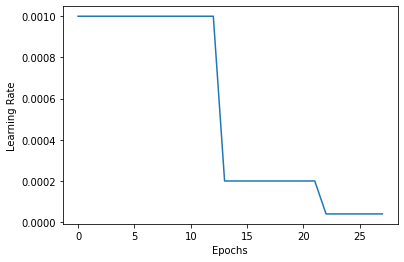

In [ ]:
plt.plot(lr_monitor.lrs['lr-Adam'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

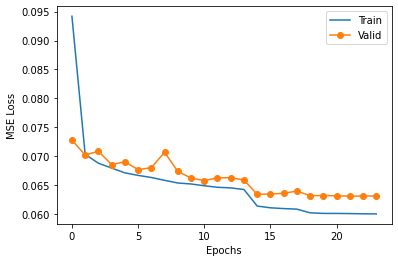

In [ ]:
plt.plot(logger.metrics['train_loss'], label='Train')
plt.plot(logger.metrics['val_loss'], marker='o', label='Valid')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
min(logger.metrics['val_loss'])

0.06863778084516525

## LSTM
In this section we will implement LSTM and see if we can improve the performance

In [ ]:
# Lightning Module

class LSTM(pl.LightningModule):
  def __init__(self, num_features, target_size):
    super().__init__()
    self.lstm = nn.LSTM(num_features, 64, 2)
    self.linear = nn.Linear(64, target_size)
    
  def forward(self, x):
    lstm_out, _  = self.lstm(x)
    output = self.linear(lstm_out[:, -1])
    return output
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

# model
num_features = len(columns)
target_size = train_y_RNN.shape[-1]
LSTM_model = LSTM(num_features, target_size)
# training
# Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
# Learning rate monitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')
logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=5)
trainer = pl.Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=30, logger=logger, callbacks=[early_stopping,checkpoint_callback],
                     default_root_dir='/content/gdrive/MyDrive/ECSE_552/HW5/LSTMNetwork_checkpoints_8steps_64units')
start_time = time.time()
trainer.fit(LSTM_model, train_dataloader_RNN, valid_dataloader_RNN)
LSTM_training_time = time.time() - start_time

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 52.5 K
1 | linear | Linear | 585   
----------------------------------
53.1 K    Trainable params
0         Non-trainable params
53.1 K    Total params
0.212     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


In [ ]:
# Training time for LSTM model
LSTM_training_time

406.23501110076904

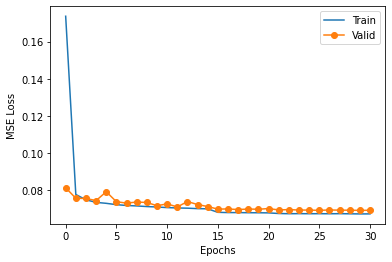

In [ ]:
plt.plot(logger.metrics['train_loss'], label='Train')
plt.plot(logger.metrics['val_loss'], marker='o', label='Valid')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
min(logger.metrics['val_loss'])

0.06784982234239578

## GRU
A GRU Network is also implemented to compare with the other two models

In [ ]:
# Lightning Module

class GRU(pl.LightningModule):
  def __init__(self, num_features, target_size):
    super().__init__()
    self.GRU = nn.GRU(num_features, 64, 2)
    self.linear = nn.Linear(64, target_size)
    
  def forward(self, x):
    GRU_out, _  = self.GRU(x)
    output = self.linear(GRU_out[:, -1])
    return output
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

# model
num_features = len(columns)
target_size = train_y_RNN.shape[-1]
GRU_model = GRU(num_features, target_size)
# training
# Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
# Learning rate monitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')
logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=5)
trainer = pl.Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=30, logger=logger, callbacks=[early_stopping,checkpoint_callback],
                     default_root_dir='/content/gdrive/MyDrive/ECSE_552/HW5/GRUNetwork_checkpoints_8steps_64units')
start_time = time.time()
trainer.fit(GRU_model, train_dataloader_RNN, valid_dataloader_RNN)
GRU_training_time = time.time() - start_time

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name   | Type   | Params
----------------------------------
0 | GRU    | GRU    | 152 K 
1 | linear | Linear | 1.2 K 
----------------------------------
153 K     Trainable params
0         Non-trainable params
153 K     Total params
0.614     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


In [ ]:
# Training time for GRU
GRU_training_time

342.17954897880554

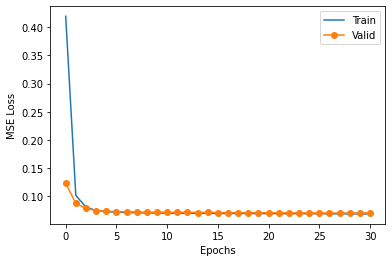

In [ ]:
plt.plot(logger.metrics['train_loss'], label='Train')
plt.plot(logger.metrics['val_loss'], marker='o', label='Valid')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
min(logger.metrics['val_loss'])

In [ ]:
summary = {"Model":['FF', 'LSTM', 'GRU'], "Loss":[0.064, 0.068, 0.068], "Train Time [s]":[211, 406, 342]}
summary_df = pd.DataFrame(summary)

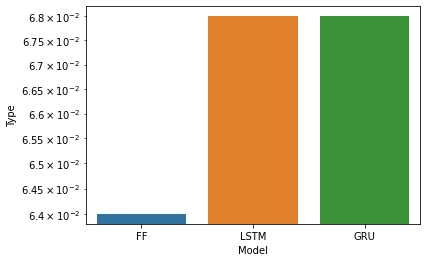

In [ ]:
g = sns.barplot( y='Loss', x='Model', data=summary_df)
g.set_yscale("log")

# Test
Now let's test our models and see how well they perform

## Pre-processing test data

In [ ]:
test_df = pd.read_csv('weather_test.csv')
date_time = pd.to_datetime(test_df['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Convert day and year into periodic data
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = 365.2425*day

test_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
test_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
test_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
test_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Convert to vectors
wv = test_df['wv (m/s)']
max_wv = test_df['max. wv (m/s)']

# Convert to radians.
wd_rad = test_df['wd (deg)']*np.pi / 180

# Calculate the wind x and y components.
test_df['Wx'] = wv*np.cos(wd_rad)
test_df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
test_df['max Wx'] = max_wv*np.cos(wd_rad)
test_df['max Wy'] = max_wv*np.sin(wd_rad)

# Standardization
test_data = test_df.iloc[:, 1:] # Remove the date time column since we've represented the date time in sine and cosine format
test_data = (test_data - train_mean)/train_std

columns_X = ['p (mbar)', 'T (degC)', 'rh (%)', 'Wx', 'Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
columns_Y = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']
test_data_final_X = test_data[columns_X].to_numpy()
test_data_final_Y = test_data[columns_Y].to_numpy()

### Dense Layers NN

In [ ]:
test_X_FF, _ = sliding_windows(test_data_final_X, window_size, num_of_output, flatten=True)
_, test_Y_FF = sliding_windows(test_data_final_Y, window_size, len(columns_Y), flatten=True)

# Make predictions
FF_predictions = FF_model(test_X_FF).detach()

# Undo standardization

test_Y_FF[:,0] *= train_std[0]
test_Y_FF[:,1] *= train_std[1]
test_Y_FF[:,2] *= train_std[4]
test_Y_FF[:,3] *= train_std[11]

test_Y_FF[:,0] += train_mean[0]
test_Y_FF[:,1] += train_mean[1]
test_Y_FF[:,2] += train_mean[4]
test_Y_FF[:,3] += train_mean[11]


FF_predictions[:,0] *= train_std[0]
FF_predictions[:,1] *= train_std[1]
FF_predictions[:,2] *= train_std[4]
FF_predictions[:,3] *= train_std[18]
FF_predictions[:,4] *= train_std[19]

FF_predictions[:,0] += train_mean[0]
FF_predictions[:,1] += train_mean[1]
FF_predictions[:,2] += train_mean[4]
FF_predictions[:,3] += train_mean[18]
FF_predictions[:,4] += train_mean[19]

# Get the wv [m/s] from 
FF_predicted_wv = torch.sqrt(torch.pow(FF_predictions[:,3],2) + torch.pow(FF_predictions[:,4],2))

In [ ]:
losses = {'model':[], 'feature':[], 'loss':[]}
loss = nn.MSELoss()
for i in range(4):
  losses['model'].append('FFNetwork')
  losses['feature'].append(columns_Y[i])
  if (i < 3):
    loss_value = float(loss(FF_predictions[:, i], test_Y_FF[:, i]).numpy())/ len(test_Y_FF)
  else:
    loss_value = float(loss(FF_predicted_wv, test_Y_FF[:, i]).numpy()) / len(test_Y_FF)

  losses['loss'].append(loss_value)

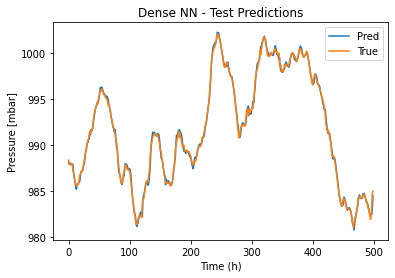

In [ ]:
# Pressure test results
plt.plot(FF_predictions[:500, 0], label='Pred')
plt.plot(test_Y_FF[:500, 0], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Pressure [mbar]')
plt.title('Dense NN - Test Predictions')
plt.show()

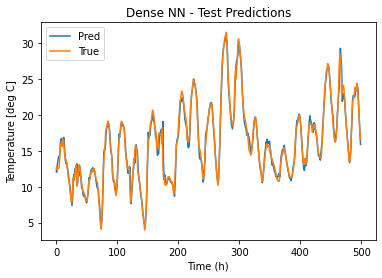

In [ ]:
# Temperature test results
plt.plot(FF_predictions[:500, 1], label='Pred')
plt.plot(test_Y_FF[:500, 1], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Temperature [deg C]')
plt.title('Dense NN - Test Predictions')
plt.show()

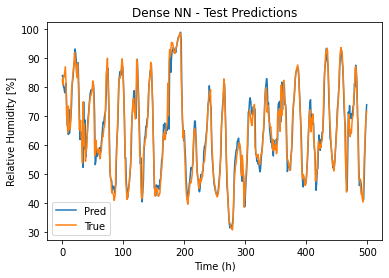

In [ ]:
# Relative Humidity test results
plt.plot(FF_predictions[:500, 2], label='Pred')
plt.plot(test_Y_FF[:500, 2], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Relative Humidity [%]')
plt.title('Dense NN - Test Predictions')
plt.show()

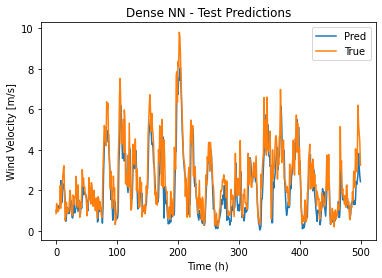

In [ ]:
# Wind Velocity train results
plt.plot(FF_predicted_wv[:500], label='Pred')
plt.plot(test_Y_FF[:500, 3], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Wind Velocity [m/s]')
plt.title('Dense NN - Test Predictions')
plt.show()

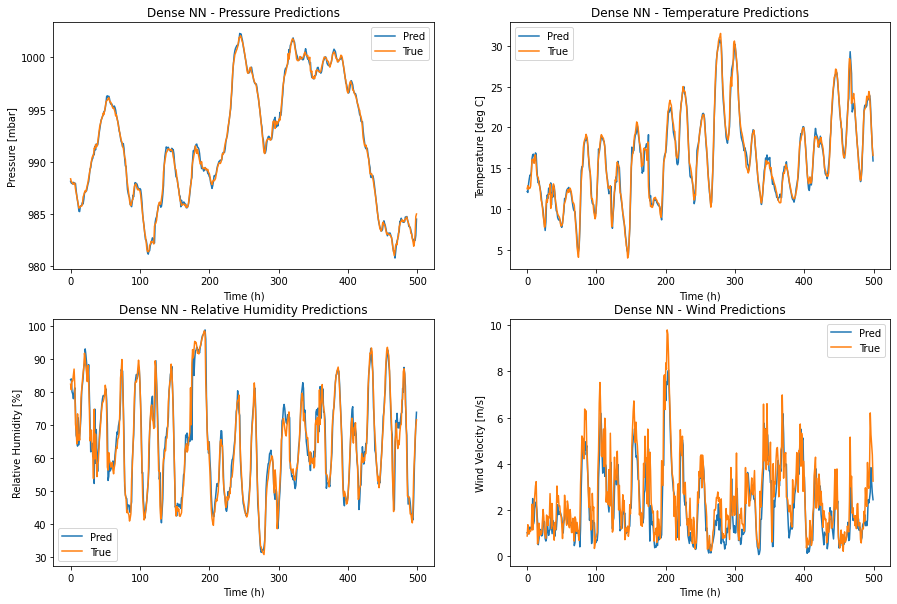

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# axs[0, 0].plot(x, y)
# axs[0, 0].set_title('Axis [0, 0]')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')


# Pressure test results
axs[0, 0].plot(FF_predictions[:500, 0], label='Pred')
axs[0, 0].plot(test_Y_FF[:500, 0], label='True')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (h)')
axs[0, 0].set_ylabel('Pressure [mbar]')
axs[0, 0].set_title('Dense NN - Pressure Predictions')

# Temperature test results
axs[0, 1].plot(FF_predictions[:500, 1], label='Pred')
axs[0, 1].plot(test_Y_FF[:500, 1], label='True')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Time (h)')
axs[0, 1].set_ylabel('Temperature [deg C]')
axs[0, 1].set_title('Dense NN - Temperature Predictions')

# Relative Humidity test results
axs[1, 0].plot(FF_predictions[:500, 2], label='Pred')
axs[1, 0].plot(test_Y_FF[:500, 2], label='True')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Time (h)')
axs[1, 0].set_ylabel('Relative Humidity [%]')
axs[1, 0].set_title('Dense NN - Relative Humidity Predictions')

# Wind Velocity train results
axs[1, 1].plot(FF_predicted_wv[:500], label='Pred')
axs[1, 1].plot(test_Y_FF[:500, 3], label='True')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Time (h)')
axs[1, 1].set_ylabel('Wind Velocity [m/s]')
axs[1, 1].set_title('Dense NN - Wind Predictions')

plt.show()

### LSTM

In [ ]:
# Make predictions
test_X_RNN, _ = sliding_windows(test_data_final_X, window_size, num_of_output, flatten=False)
_, test_Y_RNN = sliding_windows(test_data_final_Y, window_size, len(columns_Y), flatten=False)

LSTM_predictions = LSTM_model(test_X_RNN).detach()

# Undo standardization

test_Y_RNN[:,0] *= train_std[0]
test_Y_RNN[:,1] *= train_std[1]
test_Y_RNN[:,2] *= train_std[4]
test_Y_RNN[:,3] *= train_std[11]

test_Y_RNN[:,0] += train_mean[0]
test_Y_RNN[:,1] += train_mean[1]
test_Y_RNN[:,2] += train_mean[4]
test_Y_RNN[:,3] += train_mean[11]

LSTM_predictions[:,0] *= train_std[0]
LSTM_predictions[:,1] *= train_std[1]
LSTM_predictions[:,2] *= train_std[4]
LSTM_predictions[:,3] *= train_std[18]
LSTM_predictions[:,4] *= train_std[19]

LSTM_predictions[:,0] += train_mean[0]
LSTM_predictions[:,1] += train_mean[1]
LSTM_predictions[:,2] += train_mean[4]
LSTM_predictions[:,3] += train_mean[18]
LSTM_predictions[:,4] += train_mean[19]

# Get the wv [m/s] from 
LSTM_predictions_wv = torch.sqrt(torch.pow(LSTM_predictions[:,3],2) + torch.pow(LSTM_predictions[:,4],2))

In [ ]:
for i in range(4):
  losses['model'].append('LSTM')
  losses['feature'].append(columns_Y[i])
  if (i < 3):
    loss_value = float(loss(LSTM_predictions[:, i], test_Y_RNN[:, i]).numpy()) / len(test_Y_RNN)
  else:
    loss_value = float(loss(LSTM_predictions_wv, test_Y_RNN[:, i]).numpy()) / len(test_Y_RNN)

  losses['loss'].append(loss_value)

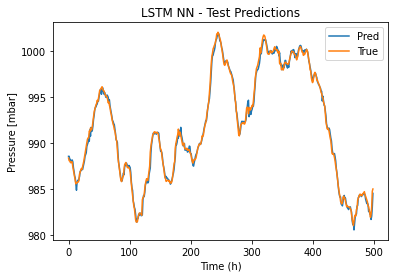

In [ ]:
# Pressure test results
plt.plot(LSTM_predictions[:500, 0], label='Pred')
plt.plot(test_Y_RNN[:500, 0], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Pressure [mbar]')
plt.title('LSTM NN - Test Predictions')
plt.show()

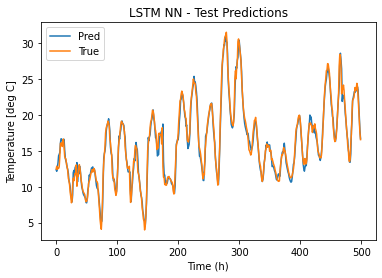

In [ ]:
# Temperature test results
plt.plot(LSTM_predictions[:500, 1], label='Pred')
plt.plot(test_Y_RNN[:500, 1], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Temperature [deg C]')
plt.title('LSTM NN - Test Predictions')
plt.show()

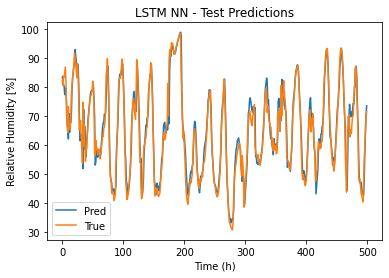

In [ ]:
# Relative Humidity test results
plt.plot(LSTM_predictions[:500, 2], label='Pred')
plt.plot(test_Y_RNN[:500, 2], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Relative Humidity [%]')
plt.title('LSTM NN - Test Predictions')
plt.show()

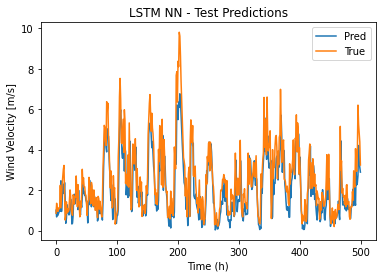

In [ ]:
# Wind Velocity train results
plt.plot(LSTM_predictions_wv[:500], label='Pred')
plt.plot(test_Y_RNN[:500, 3], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Wind Velocity [m/s]')
plt.title('LSTM NN - Test Predictions')
plt.show()

### GRU

In [ ]:
# Make predictions
test_X_RNN, _ = sliding_windows(test_data_final_X, window_size, num_of_output, flatten=False)
_, test_Y_RNN = sliding_windows(test_data_final_Y, window_size, len(columns_Y), flatten=False)

GRU_predictions = GRU_model(test_X_RNN).detach()

# Undo standardization

test_Y_RNN[:,0] *= train_std[0]
test_Y_RNN[:,1] *= train_std[1]
test_Y_RNN[:,2] *= train_std[4]
test_Y_RNN[:,3] *= train_std[11]

test_Y_RNN[:,0] += train_mean[0]
test_Y_RNN[:,1] += train_mean[1]
test_Y_RNN[:,2] += train_mean[4]
test_Y_RNN[:,3] += train_mean[11]

GRU_predictions[:,0] *= train_std[0]
GRU_predictions[:,1] *= train_std[1]
GRU_predictions[:,2] *= train_std[4]
GRU_predictions[:,3] *= train_std[18]
GRU_predictions[:,4] *= train_std[19]

GRU_predictions[:,0] += train_mean[0]
GRU_predictions[:,1] += train_mean[1]
GRU_predictions[:,2] += train_mean[4]
GRU_predictions[:,3] += train_mean[18]
GRU_predictions[:,4] += train_mean[19]

# Get the wv [m/s] from 
GRU_predictions_wv = torch.sqrt(torch.pow(GRU_predictions[:,3],2) + torch.pow(GRU_predictions[:,4],2))

In [ ]:
for i in range(4):
  losses['model'].append('GRU')
  losses['feature'].append(columns_Y[i])
  if (i < 3):
    loss_value = float(loss(GRU_predictions[:, i], test_Y_RNN[:, i]).numpy()) / len(test_Y_RNN)
  else:
    loss_value = float(loss(GRU_predictions_wv, test_Y_RNN[:, i]).numpy()) / len(test_Y_RNN)
  losses['loss'].append(loss_value)

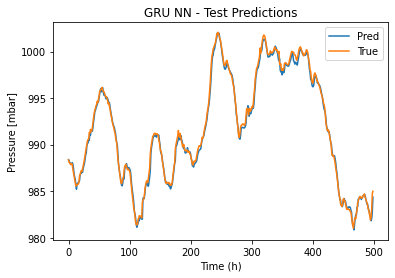

In [ ]:
# Pressure test results
plt.plot(GRU_predictions[:500, 0], label='Pred')
plt.plot(test_Y_RNN[:500, 0], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Pressure [mbar]')
plt.title('GRU NN - Test Predictions')
plt.show()

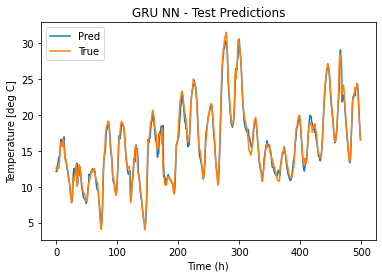

In [ ]:
# Temperature test results
plt.plot(GRU_predictions[:500, 1], label='Pred')
plt.plot(test_Y_RNN[:500, 1], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Temperature [deg C]')
plt.title('GRU NN - Test Predictions')
plt.show()

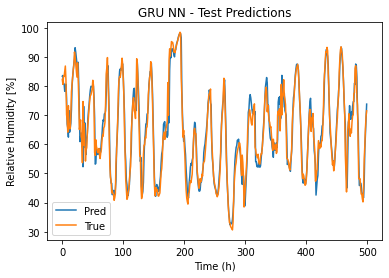

In [ ]:
# Relative Humidity test results
plt.plot(GRU_predictions[:500, 2], label='Pred')
plt.plot(test_Y_RNN[:500, 2], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Relative Humidity [%]')
plt.title('GRU NN - Test Predictions')
plt.show()

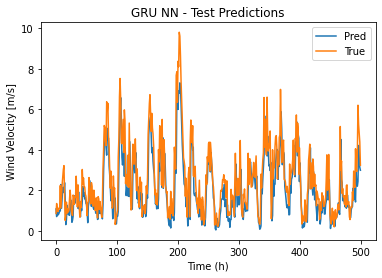

In [ ]:
# Wind Velocity train results
plt.plot(GRU_predictions_wv[:500], label='Pred')
plt.plot(test_Y_RNN[:500, 3], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Wind Velocity [m/s]')
plt.title('GRU NN - Test Predictions')
plt.show()

### Individual Loss comparison

In [ ]:
loss_df = pd.DataFrame(losses)
loss_df

,model,feature,loss
0,FFNetwork,p (mbar),0.006216
1,FFNetwork,T (degC),0.004131
2,FFNetwork,rh (%),0.082321
3,FFNetwork,wv (m/s),3.628812
4,LSTM,p (mbar),0.000021
5,LSTM,T (degC),0.000037
6,LSTM,rh (%),0.000931
7,LSTM,wv (m/s),1.531176
8,GRU,p (mbar),0.000014
9,GRU,T (degC),0.000037


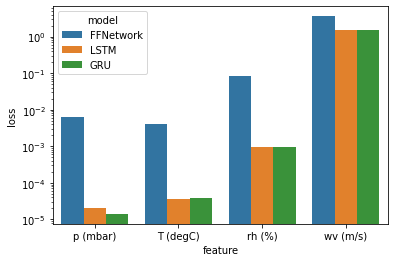

In [ ]:
loss_df = pd.DataFrame(losses)
g = sns.barplot(x='feature', y='loss', hue='model', data=loss_df)
g.set_yscale("log")

### Overall Performance Comparison

In [ ]:
loss_overall = {'model': [], 'loss': []}
# FFNetwork
FF_predictions_overall = np.zeros_like(FF_predictions[:, :4])
FF_predictions_overall[:, :3] = FF_predictions[:, :3]
FF_predictions_overall[:, 3] = FF_predicted_wv
FF_loss = loss(torch.from_numpy(FF_predictions_overall).float(), test_Y_FF) / len(test_Y_FF)
loss_overall['model'].append('FFNetwork')
loss_overall['loss'].append(float(FF_loss.numpy()))

# LSTM
LSTM_predictions_overall = np.zeros_like(LSTM_predictions[:, :4])
LSTM_predictions_overall[:, :3] = LSTM_predictions[:, :3]
LSTM_predictions_overall[:, 3] = LSTM_predictions_wv
LSTM_loss = loss(torch.from_numpy(LSTM_predictions_overall).float(), test_Y_RNN) / len(test_Y_RNN)
loss_overall['model'].append('LSTM')
loss_overall['loss'].append(float(LSTM_loss.numpy()))

# GRU
GRU_predictions_overall = np.zeros_like(GRU_predictions[:, :4])
GRU_predictions_overall[:, :3] = GRU_predictions[:, :3]
GRU_predictions_overall[:, 3] = GRU_predictions_wv
GRU_loss = loss(torch.from_numpy(GRU_predictions_overall).float(), test_Y_RNN) / len(test_Y_RNN)
loss_overall['model'].append('GRU')
loss_overall['loss'].append(float(GRU_loss.numpy()))

In [ ]:
loss_overall_df = pd.DataFrame(loss_overall)
loss_overall_df

,model,loss
0,FFNetwork,0.930370
1,LSTM,0.383041
2,GRU,0.382875


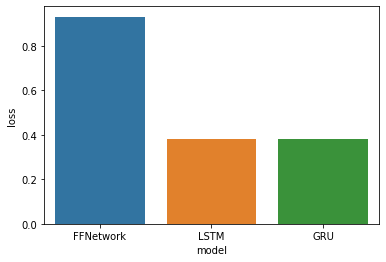

In [ ]:
g = sns.barplot(x='model', y='loss', data=loss_overall_df)
plt.show()

# Error Propagation
In this section, I would like to implement an auto-regressive loop and study how error propagations with the increase in the number of time steps. Specifically, I will merge the values predicted by the first time step with the seven time steps of the original training data as a new input for the second time step prediction, and repeat this process for eight time steps. 

## Dense Layer

In [ ]:
# Lightning Module

class FFNetwork(pl.LightningModule):
  def __init__(self, num_features, window_size, target_size):
    super().__init__()
    self.network = nn.Sequential(nn.Linear(num_features*window_size, 64), 
                                 nn.LeakyReLU(),
                                 nn.Linear(64, 64),
                                 nn.LeakyReLU(),
                                 nn.Linear(64, target_size))
    
  def forward(self, x):
    output = self.network(x)
    return output
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self.network(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self.network(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

# model
num_features = len(columns)
target_size = train_y_FF.shape[-1]
FF_model = FFNetwork(num_features, window_size, target_size)
FF_model = FF_model.load_from_checkpoint(checkpoint_path='/content/gdrive/MyDrive/ECSE_552/HW5/FFNetwork_checkpoints_8steps_64units/DictLogger/0.1/checkpoints/epoch=27-step=62803.ckpt', 
                                         num_features=num_features,window_size=window_size, target_size=target_size)

In [ ]:
FF_predictions_propagation = []
_, test_Y_FF = sliding_windows(test_data_final_Y, window_size, len(columns_Y), flatten=True)
test_X_FF, _ = sliding_windows(test_data_final_X, window_size, num_of_output, flatten=True)

# Undo standardization

test_Y_FF[:,0] *= train_std[0]
test_Y_FF[:,1] *= train_std[1]
test_Y_FF[:,2] *= train_std[4]
test_Y_FF[:,3] *= train_std[11]

test_Y_FF[:,0] += train_mean[0]
test_Y_FF[:,1] += train_mean[1]
test_Y_FF[:,2] += train_mean[4]
test_Y_FF[:,3] += train_mean[11]
for i in range(window_size):
  FF_predictions = FF_model(test_X_FF).detach()
  FF_predictions_propagation.append(FF_predictions)
  new_test_X_FF = np.zeros_like(test_X_FF)
  new_test_X_FF[:, :-window_size] = test_X_FF[:, window_size:]
  new_test_X_FF[:, -window_size-1:] = FF_predictions
  test_X_FF = torch.from_numpy(new_test_X_FF).float()

In [ ]:
# Undo standardization
FF_predicted_wv_propagation = []
for FF_predictions in FF_predictions_propagation:

  FF_predictions[:,0] *= train_std[0]
  FF_predictions[:,1] *= train_std[1]
  FF_predictions[:,2] *= train_std[4]
  FF_predictions[:,3] *= train_std[18]
  FF_predictions[:,4] *= train_std[19]

  FF_predictions[:,0] += train_mean[0]
  FF_predictions[:,1] += train_mean[1]
  FF_predictions[:,2] += train_mean[4]
  FF_predictions[:,3] += train_mean[18]
  FF_predictions[:,4] += train_mean[19]

  # Get the wv [m/s] from 
  FF_predicted_wv = torch.sqrt(torch.pow(FF_predictions[:,3],2) + torch.pow(FF_predictions[:,4],2))
  FF_predicted_wv_propagation.append(FF_predicted_wv)

## LSTM

In [ ]:
# Lightning Module

class LSTM(pl.LightningModule):
  def __init__(self, num_features, target_size):
    super().__init__()
    self.lstm = nn.LSTM(num_features, 64, 2)
    self.linear = nn.Linear(64, target_size)
    
  def forward(self, x):
    lstm_out, _  = self.lstm(x)
    output = self.linear(lstm_out[:, -1])
    return output
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

# model
num_features = len(columns)
target_size = train_y_RNN.shape[-1]
LSTM_model = LSTM(num_features, target_size)
LSTM_model = LSTM_model.load_from_checkpoint(checkpoint_path='/content/gdrive/MyDrive/ECSE_552/HW5/LSTMNetwork_checkpoints_8steps_64units/DictLogger/0.1/checkpoints/epoch=32-step=74018.ckpt',
                                             num_features=num_features, window_size=window_size, target_size=target_size)

In [ ]:
LSTM_predictions_propagation = []
test_X_RNN, _ = sliding_windows(test_data_final_X, window_size, num_of_output, flatten=False)
_, test_Y_RNN = sliding_windows(test_data_final_Y, window_size, len(columns_Y), flatten=False)

# Undo standardization

test_Y_RNN[:,0] *= train_std[0]
test_Y_RNN[:,1] *= train_std[1]
test_Y_RNN[:,2] *= train_std[4]
test_Y_RNN[:,3] *= train_std[11]

test_Y_RNN[:,0] += train_mean[0]
test_Y_RNN[:,1] += train_mean[1]
test_Y_RNN[:,2] += train_mean[4]
test_Y_RNN[:,3] += train_mean[11]
for i in range(window_size):
  LSTM_predictions = LSTM_model(test_X_RNN).detach()
  LSTM_predictions_propagation.append(LSTM_predictions)
  new_test_X_RNN = np.zeros_like(test_X_RNN)
  new_test_X_RNN[:, :-1, :] = test_X_RNN[:, 1:, :]
  new_test_X_RNN[:, -1:, :] = LSTM_predictions.reshape((LSTM_predictions.shape[0], 1, LSTM_predictions.shape[1]))
  test_X_RNN = torch.from_numpy(new_test_X_RNN).float()

In [ ]:
# Undo standardization
LSTM_predicted_wv_propagation = []
for LSTM_predictions in LSTM_predictions_propagation:

  LSTM_predictions[:,0] *= train_std[0]
  LSTM_predictions[:,1] *= train_std[1]
  LSTM_predictions[:,2] *= train_std[4]
  LSTM_predictions[:,3] *= train_std[18]
  LSTM_predictions[:,4] *= train_std[19]

  LSTM_predictions[:,0] += train_mean[0]
  LSTM_predictions[:,1] += train_mean[1]
  LSTM_predictions[:,2] += train_mean[4]
  LSTM_predictions[:,3] += train_mean[18]
  LSTM_predictions[:,4] += train_mean[19]

  # Get the wv [m/s] from 
  LSTM_predicted_wv = torch.sqrt(torch.pow(LSTM_predictions[:,3],2) + torch.pow(LSTM_predictions[:,4],2))
  LSTM_predicted_wv_propagation.append(LSTM_predicted_wv)

## GRU

In [ ]:
# Lightning Module

class GRU(pl.LightningModule):
  def __init__(self, num_features, target_size):
    super().__init__()
    self.GRU = nn.GRU(num_features, 64, 2)
    self.linear = nn.Linear(64, target_size)
    
  def forward(self, x):
    GRU_out, _  = self.GRU(x)
    output = self.linear(GRU_out[:, -1])
    return output
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

# model
num_features = len(columns)
target_size = train_y_RNN.shape[-1]
GRU_model = GRU(num_features, target_size)

GRU_model = GRU_model.load_from_checkpoint(checkpoint_path='/content/gdrive/MyDrive/ECSE_552/HW5/GRUNetwork_checkpoints_8steps_64units/DictLogger/0.1/checkpoints/epoch=22-step=51588.ckpt',
                                             num_features=num_features, window_size=window_size, target_size=target_size)

In [ ]:
GRU_predictions_propagation = []
test_X_RNN, _ = sliding_windows(test_data_final_X, window_size, num_of_output, flatten=False)
for i in range(window_size):
  GRU_predictions = GRU_model(test_X_RNN).detach()
  GRU_predictions_propagation.append(GRU_predictions)
  new_test_X_RNN = np.zeros_like(test_X_RNN)
  new_test_X_RNN[:, :-1, :] = test_X_RNN[:, 1:, :]
  new_test_X_RNN[:, -1:, :] = GRU_predictions.reshape((GRU_predictions.shape[0], 1, GRU_predictions.shape[1]))
  test_X_RNN = torch.from_numpy(new_test_X_RNN).float()

In [ ]:
# Undo standardization
GRU_predicted_wv_propagation = []
for GRU_predictions in GRU_predictions_propagation:

  GRU_predictions[:,0] *= train_std[0]
  GRU_predictions[:,1] *= train_std[1]
  GRU_predictions[:,2] *= train_std[4]
  GRU_predictions[:,3] *= train_std[18]
  GRU_predictions[:,4] *= train_std[19]

  GRU_predictions[:,0] += train_mean[0]
  GRU_predictions[:,1] += train_mean[1]
  GRU_predictions[:,2] += train_mean[4]
  GRU_predictions[:,3] += train_mean[18]
  GRU_predictions[:,4] += train_mean[19]

  # Get the wv [m/s] from 
  GRU_predicted_wv = torch.sqrt(torch.pow(GRU_predictions[:,3],2) + torch.pow(GRU_predictions[:,4],2))
  GRU_predicted_wv_propagation.append(GRU_predicted_wv)

In [ ]:
losses_propagation = {'model': [], 'step': [], 'loss': []}
loss = nn.MSELoss()
i = 0
# FFNetwork
for FF_predictions in FF_predictions_propagation:
  losses_propagation['step'].append(i+1)
  FF_predictions_overall = np.zeros_like(FF_predictions[:, :4])
  FF_predictions_overall[:, :3] = FF_predictions[:, :3]
  FF_predictions_overall[:, 3] = FF_predicted_wv_propagation[i]
  if i == 0:
    FF_loss = loss(torch.from_numpy(FF_predictions_overall).float(), test_Y_FF) / len(FF_predictions_overall)
  else:
    FF_loss = loss(torch.from_numpy(FF_predictions_overall[:-i]).float(), test_Y_FF[i:]) / len(FF_predictions_overall[:-i])
  losses_propagation['model'].append('FFNetwork')
  losses_propagation['loss'].append(float(FF_loss.numpy()))
  i += 1

i = 0
# LSTM
for LSTM_predictions in LSTM_predictions_propagation:
  losses_propagation['step'].append(i+1)
  LSTM_predictions_overall = np.zeros_like(LSTM_predictions[:, :4])
  LSTM_predictions_overall[:, :3] = LSTM_predictions[:, :3]
  LSTM_predictions_overall[:, 3] = LSTM_predicted_wv_propagation[i]
  if i == 0:
    LSTM_loss = loss(torch.from_numpy(LSTM_predictions_overall).float(), test_Y_RNN) / len(LSTM_predictions_overall)
  else:
    LSTM_loss = loss(torch.from_numpy(LSTM_predictions_overall[:-i]).float(), test_Y_RNN[i:]) / len(LSTM_predictions_overall[:-i])
  losses_propagation['model'].append('LSTM')
  losses_propagation['loss'].append(float(LSTM_loss.numpy()))
  i += 1

i = 0
# GRU
for GRU_predictions in GRU_predictions_propagation:
  losses_propagation['step'].append(i+1) 
  GRU_predictions_overall = np.zeros_like(GRU_predictions[:, :4])
  GRU_predictions_overall[:, :3] = GRU_predictions[:, :3]
  GRU_predictions_overall[:, 3] = GRU_predicted_wv_propagation[i]
  if i == 0:
    GRU_loss = loss(torch.from_numpy(GRU_predictions_overall).float(), test_Y_RNN) / len(GRU_predictions_overall)
  else:
    GRU_loss = loss(torch.from_numpy(GRU_predictions_overall[:-i]).float(), test_Y_RNN[i:]) / len(GRU_predictions_overall[:-i])
  losses_propagation['model'].append('GRU')
  i += 1
  losses_propagation['loss'].append(float(GRU_loss.numpy()))

In [ ]:
losses_prop_df = pd.DataFrame(losses_propagation)
losses_prop_df

,model,step,loss
0,FFNetwork,1,0.930370
1,FFNetwork,2,0.613322
2,FFNetwork,3,0.514702
3,FFNetwork,4,0.561689
4,FFNetwork,5,0.825644
5,FFNetwork,6,1.405225
6,FFNetwork,7,2.605263
7,FFNetwork,8,1.771705
8,LSTM,1,0.383041
9,LSTM,2,0.383049


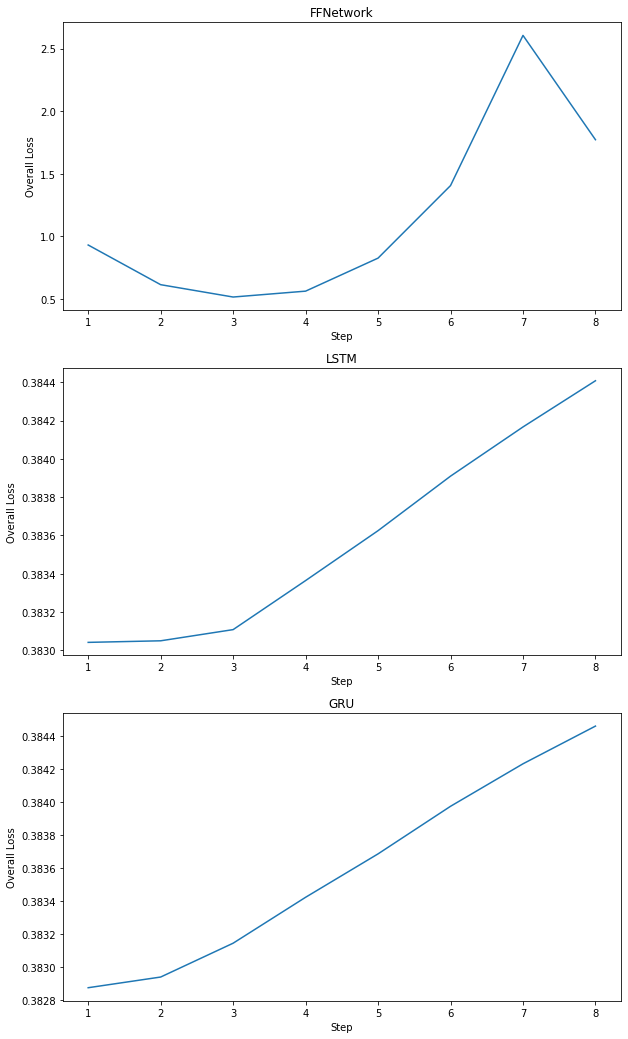

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
  # FF Network
  model = losses_prop_df['model'].unique()[i]
  axs[i].plot(losses_prop_df[losses_prop_df['model']==model]['step'].values, losses_prop_df[losses_prop_df['model']==model]['loss'].values)
  axs[i].set_xlabel('Step')
  axs[i].set_ylabel('Overall Loss')
  axs[i,].set_title(model)

plt.show()

# Test Using Wind and Time (integer) Directly
During preprocessing, I converted time into sine and cosine waves. I also combined wind speed and wind angle into wind vectors. In this section I would like to check if this preprocessing helps the model performance.

In [ ]:
train_df = pd.read_csv('weather_train.csv')
train_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [ ]:
date_time = pd.to_datetime(train_df['Date Time'], format='%d.%m.%Y %H:%M:%S')
train_df['Hour'] = date_time.dt.hour
train_df['Month'] = date_time.dt.month

In [ ]:
# Columns that we will use to make predictions
columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'Hour', 'Month']
train_df = train_df[columns]

In [ ]:
# 80% for train and 20% for validation
n = len(train_df)
train_data = train_df[:int(n*0.8)]
valid_data = train_df[int(n*0.8):]

In [ ]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean)/train_std
valid_data = (valid_data - train_mean)/train_std

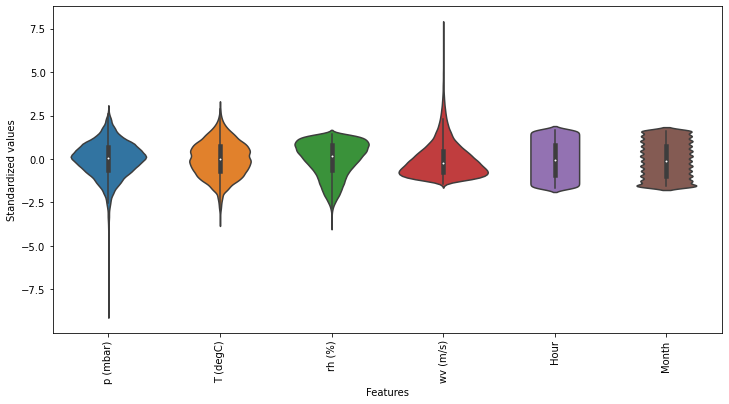

In [ ]:
df_std = train_data
df_std = df_std.melt(var_name='Features', value_name='Standardized values') # To make the violin plot, we can only have one column for x and one column for y
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Features', y='Standardized values', data=df_std)
_ = ax.set_xticklabels(columns, rotation=90)

In [ ]:
train_data_final = train_data[columns].to_numpy()
valid_data_final = valid_data[columns].to_numpy()

In [ ]:
# Create sliding windows
def sliding_windows(data, window_size, num_of_output, flatten=False):
  """
  Function to expand features to a sliding window
  The first "num_of_output" columns of data are taken as outputs
  If flatten is set to True:
    New number of features = number of features * sliding window size
    New number of time steps = number of time steps - sliding window size
  """
  x = []
  y = []
  for i in range(len(data)-window_size-1):
    _x = data[i:(i+window_size), :]
    _y = data[i+window_size, :num_of_output]
    x.append(_x)
    y.append(_y)

  x = np.array(x)
  y = np.array(y)
  
  # Flatten the feature and window dimensions
  if flatten:
    x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
  return (torch.from_numpy(x).float(), torch.from_numpy(y).float())

window_size = 8
num_of_output = len(columns)

# For RNN, we don't need to flat the input
train_X_RNN, train_y_RNN = sliding_windows(train_data_final, window_size, num_of_output, flatten=False)
valid_X_RNN, valid_y_RNN = sliding_windows(valid_data_final, window_size, num_of_output, flatten=False)

In [ ]:
# RNN
train_data_RNN = TensorDataset(train_X_RNN, train_y_RNN)
valid_data_RNN = TensorDataset(valid_X_RNN, valid_y_RNN)

train_dataloader_RNN = DataLoader(train_data_RNN, batch_size=20, shuffle=True)
valid_dataloader_RNN = DataLoader(valid_data_RNN, batch_size=20, shuffle=True)

In [ ]:
# Lightning Module

class GRU(pl.LightningModule):
  def __init__(self, num_features, target_size):
    super().__init__()
    self.GRU = nn.GRU(num_features, 64, 2)
    self.linear = nn.Linear(64, target_size)
    
  def forward(self, x):
    GRU_out, _  = self.GRU(x)
    output = self.linear(GRU_out[:, -1])
    return output
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

# model
num_features = len(columns)
target_size = train_y_RNN.shape[-1]
GRU_model = GRU(num_features, target_size)

GRU_model = GRU_model.load_from_checkpoint('/content/gdrive/MyDrive/ECSE_552/HW5/GRUNetwork_checkpoints_TestIntegerTimeAndWV/DictLogger/0.1/checkpoints/epoch=24-step=56074.ckpt',
                                           num_features=num_features, target_size=target_size)
# # training
# # Init ModelCheckpoint callback, monitoring 'val_loss'
# checkpoint_callback = ModelCheckpoint(monitor='val_loss')
# # Learning rate monitor
# lr_monitor = LearningRateMonitor(logging_interval='epoch')
# logger = DictLogger()
# early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=5)
# trainer = pl.Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=30, logger=logger, callbacks=[early_stopping,checkpoint_callback],
#                      default_root_dir='/content/gdrive/MyDrive/ECSE_552/HW5/GRUNetwork_checkpoints_TestIntegerTimeAndWV/')
# start_time = time.time()
# trainer.fit(GRU_model, train_dataloader_RNN, valid_dataloader_RNN)
# GRU_training_time = time.time() - start_time

In [ ]:
test_df = pd.read_csv('weather_test.csv')
date_time = pd.to_datetime(test_df['Date Time'], format='%d.%m.%Y %H:%M:%S')
test_df['Hour'] = date_time.dt.hour
test_df['Month'] = date_time.dt.month

# Columns that we will use to make predictions
columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'Hour', 'Month']
test_data = test_df[columns]
test_data = (test_data - train_mean)/train_std

columns_Y = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']
test_data_final_X = test_data.to_numpy()
test_data_final_Y = test_data[columns_Y].to_numpy()

In [ ]:
# Make predictions
test_X_RNN, _ = sliding_windows(test_data_final_X, window_size, num_of_output, flatten=False)
_, test_Y_RNN = sliding_windows(test_data_final_Y, window_size, len(columns_Y), flatten=False)

GRU_predictions = GRU_model(test_X_RNN).detach()

# Undo standardization

test_Y_RNN[:,0] *= train_std[0]
test_Y_RNN[:,1] *= train_std[1]
test_Y_RNN[:,2] *= train_std[2]
test_Y_RNN[:,3] *= train_std[3]

test_Y_RNN[:,0] += train_mean[0]
test_Y_RNN[:,1] += train_mean[1]
test_Y_RNN[:,2] += train_mean[2]
test_Y_RNN[:,3] += train_mean[3]

GRU_predictions[:,0] *= train_std[0]
GRU_predictions[:,1] *= train_std[1]
GRU_predictions[:,2] *= train_std[2]
GRU_predictions[:,3] *= train_std[3]

GRU_predictions[:,0] += train_mean[0]
GRU_predictions[:,1] += train_mean[1]
GRU_predictions[:,2] += train_mean[2]
GRU_predictions[:,3] += train_mean[3]


In [ ]:
losses_GRU = {'feature':[], 'loss':[]}
loss = nn.MSELoss()
for i in range(4):
  losses_GRU['feature'].append(columns_Y[i])
  loss_value = float(loss(GRU_predictions[:, i], test_Y_RNN[:, i]).numpy()) / len(test_Y_RNN)
  losses_GRU['loss'].append(loss_value)

In [ ]:
pd.DataFrame(losses_GRU)

,feature,loss
0,p (mbar),0.000028
1,T (degC),0.000046
2,rh (%),0.001039
3,wv (m/s),1.529136


In [ ]:
loss_df[loss_df['model']=='GRU']

,model,feature,loss
8,GRU,p (mbar),0.000014
9,GRU,T (degC),0.000037
10,GRU,rh (%),0.000954
11,GRU,wv (m/s),1.530495


In [ ]:
comparison = {'Preprocessing':['With Preprocessing', 'With Preprocessing', 'With Preprocessing', 'With Preprocessing','Without Preprocessing', 'Without Preprocessing', 'Without Preprocessing', 'Without Preprocessing'],
              'feature': ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)'],
              'loss': [0.000014, 0.000037, 0.000954, 1.530495, 0.000028, 0.000046, 0.001039, 1.529136]}


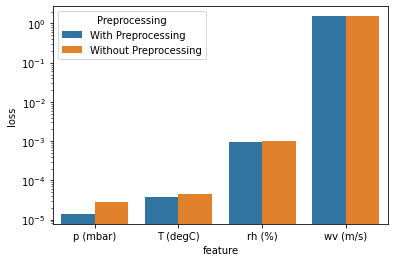

In [ ]:
comparison_df = pd.DataFrame(comparison)
g = sns.barplot(x='feature', y='loss', hue='Preprocessing', data=comparison_df)
g.set_yscale("log")